In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy import stats
from scipy.stats import ttest_ind, mannwhitneyu
import statsmodels.stats.proportion as proportion

# Исследование подгруженных данных

# Файл с заказами

In [3]:
orders= pd.read_excel('Новый диплом датасет.xlsx',sheet_name ='Данные')
orders.head(5)

,id_order,id_client,amt_payment,dtime_pay
0,162295,203943.0,2802.0,2022-10-17 20:38:22.304000
1,185621,206742.0,4404.0,2022-12-13 09:47:43.880000
2,267875,183601.0,5192.0,2022-09-07 11:14:52.440000
3,173557,203446.0,2438.0,2022-09-07 08:23:40.021000
4,239130,188188.0,2488.0,2022-09-06 00:16:37.306000


In [44]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36519 entries, 0 to 38690
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id_order     36519 non-null  int64  
 1   id_client    36519 non-null  float64
 2   amt_payment  36519 non-null  float64
 3   dtime_pay    36519 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 1.4+ MB


In [5]:
non_amount = len(orders[orders['amt_payment'].isnull()]['amt_payment'])
non_time_pay = len(orders[orders['dtime_pay'].isnull()]['dtime_pay'])
non_client = len(orders[orders['id_client'].isnull()]['id_client'])

print('нет оплату у ', non_amount ,'записей')
print('нет времени платежа у ', non_time_pay ,'записей')
print('нет id_client у ', non_client ,'записей')

нет оплату у  2155 записей
нет времени платежа у  2172 записей
нет id_client у  588 записей


# Решение:
    1. Удалить записи без id_client т.к. не позволит оценивать работу AB-теста.
    2. Удалить записи без оплат, это либо возвраты, либо отмены, будут мешать

In [6]:
# очистка от нулевых значений

orders = orders[~orders['id_client'].isnull()]
orders = orders[~orders['amt_payment'].isnull()]

In [7]:
# после очистки от нулевых оплат, есть часть записей, где оплата есть, но нет даты
no_time_pay= orders[orders['dtime_pay'].isnull()]['amt_payment']
no_time_pay

2449     3642.0
3452     3000.0
3518     3188.0
10908    5525.0
11256    5206.0
11578    5445.0
12594    5166.0
14946    3338.0
18698    3723.0
19665    4450.0
20597    5937.0
24506    4015.0
26945    5637.0
28973    3628.0
32634    5072.0
32725    3615.0
33460    3644.0
Name: amt_payment, dtype: float64

# Решение: 
    Отправить эти данные инженерам, чтобы выяснили причину оплат без даты платежа.
    Считаю, что платеж не состоялся, удаляю из данных о заказах

In [8]:
# очистка от данных без даты оплат

orders = orders[~orders['dtime_pay'].isnull()]

# Файл с клиентами и инфо о АВ-тесте

In [9]:
clients= pd.read_excel('Новый диплом датасет.xlsx',sheet_name ='Clients')
clients.head(5)

,id_client,dtime_ad,nflag_test,id_trading_point
0,180844,2022-06-08 18:38:41.414,0,212
1,193942,NaT,0,13
2,226069,2022-07-11 16:28:38.511,1,54
3,183981,2022-06-16 12:23:59.289,1,991
4,322530,2022-07-08 08:56:08.714,0,1015


In [10]:
clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55605 entries, 0 to 55604
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   id_client         55605 non-null  int64         
 1   dtime_ad          55356 non-null  datetime64[ns]
 2   nflag_test        55605 non-null  int64         
 3   id_trading_point  55605 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 1.7 MB


In [11]:
non_dtime_ad = len(clients[clients['dtime_ad'].isnull()])

print('нет времени показа у ', non_dtime_ad ,'записей')

нет времени показа у  249 записей


# Решение:
    Удалить клиентов (249), по которым нет времени показа, т.к. общее количество клиентов 55605, что не исказит результатов исследования.

In [12]:
# очистка от слиентов без времени показа
clients = clients[~clients['dtime_ad'].isnull()]

# Файл с городами и ТТ

In [13]:
region_dict = pd.read_excel('Новый диплом датасет.xlsx',sheet_name ='Region_dict')
region_dict

,id_trading_point,city
0,1,Петрозаводск
1,2,Дмитров
2,4,Чехов
3,7,Ростов Великий
4,11,Владимир
...,...,...
61,3987,Москва
62,6543,Москва
63,8543,Москва
64,9121,Москва


# Исследование рабочих ТТ по городам

In [14]:
# подтяну к клиентам города
df_cities = clients.merge(region_dict, on ='id_trading_point')
df_cities.head(5)


,id_client,dtime_ad,nflag_test,id_trading_point,city
0,180844,2022-06-08 18:38:41.414,0,212,Красноярск
1,223863,2022-08-20 21:56:54.325,0,212,Красноярск
2,201715,2022-07-30 19:07:49.264,1,212,Красноярск
3,292010,2022-07-26 20:37:16.885,1,212,Красноярск
4,190438,2022-07-02 12:53:04.753,1,212,Красноярск


In [15]:
df_cities_gr = df_cities.groupby(['city']).agg({'id_trading_point':'nunique','id_client':'count'}).reset_index()
df_cities_gr = df_cities_gr.sort_values(by=['id_trading_point','id_client'], ascending = False).reset_index()
df_cities_gr.head(5)

,index,city,id_trading_point,id_client
0,7,Москва,11,12358
1,15,Санкт-Петербург,11,8879
2,10,Новосибирск,6,5188
3,4,Казань,6,5077
4,6,Красноярск,5,5937


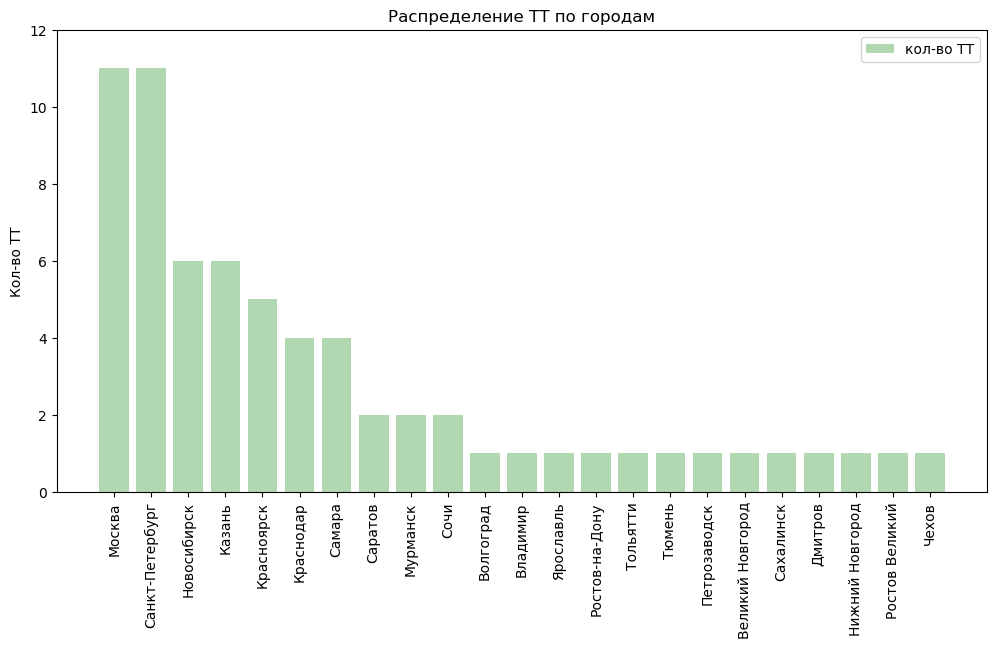

In [16]:
fig, (ax) = plt.subplots(figsize=(12, 6))

ax.bar(df_cities_gr['city'], df_cities_gr['id_trading_point'], color='green', alpha =0.3, label= 'кол-во ТТ' )

ax.set_ylim(0, (df_cities_gr['id_trading_point'].max()+1) )
plt.legend(loc = 'upper right')
plt.ylabel('Кол-во ТТ')
ax.set_title('Распределение ТТ по городам')
ax.xaxis.set_tick_params(rotation =90)

plt.show()

# Объединение данных

In [17]:
orders_by_clients = orders.groupby(['id_client']).agg({'id_order':'count','amt_payment':'sum'}).reset_index()
orders_by_clients.head(5)

,id_client,id_order,amt_payment
0,178561.0,1,3052.0
1,178562.0,1,2439.0
2,178563.0,1,768.0
3,178565.0,1,958.0
4,178566.0,1,5474.0


In [18]:
df_test = clients.merge(orders_by_clients, how ='left', on = 'id_client')
df_test.head(5)

,id_client,dtime_ad,nflag_test,id_trading_point,id_order,amt_payment
0,180844,2022-06-08 18:38:41.414,0,212,1.0,5349.0
1,226069,2022-07-11 16:28:38.511,1,54,NaN,NaN
2,183981,2022-06-16 12:23:59.289,1,991,2.0,6322.0
3,322530,2022-07-08 08:56:08.714,0,1015,NaN,NaN
4,254313,2022-06-19 22:18:01.770,1,453,NaN,NaN


In [19]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55356 entries, 0 to 55355
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   id_client         55356 non-null  int64         
 1   dtime_ad          55356 non-null  datetime64[ns]
 2   nflag_test        55356 non-null  int64         
 3   id_trading_point  55356 non-null  int64         
 4   id_order          28802 non-null  float64       
 5   amt_payment       28802 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 3.0 MB


In [20]:
# Заполняем нулями поля, где не было покупок
df_test.fillna(0, inplace=True)
df_test.head(5)

,id_client,dtime_ad,nflag_test,id_trading_point,id_order,amt_payment
0,180844,2022-06-08 18:38:41.414,0,212,1.0,5349.0
1,226069,2022-07-11 16:28:38.511,1,54,0.0,0.0
2,183981,2022-06-16 12:23:59.289,1,991,2.0,6322.0
3,322530,2022-07-08 08:56:08.714,0,1015,0.0,0.0
4,254313,2022-06-19 22:18:01.770,1,453,0.0,0.0


In [21]:
df_test = df_test.merge(region_dict, on ='id_trading_point')
df_test.head(5)

,id_client,dtime_ad,nflag_test,id_trading_point,id_order,amt_payment,city
0,180844,2022-06-08 18:38:41.414,0,212,1.0,5349.0,Красноярск
1,223863,2022-08-20 21:56:54.325,0,212,0.0,0.0,Красноярск
2,201715,2022-07-30 19:07:49.264,1,212,1.0,4171.0,Красноярск
3,292010,2022-07-26 20:37:16.885,1,212,0.0,0.0,Красноярск
4,190438,2022-07-02 12:53:04.753,1,212,1.0,6026.0,Красноярск


In [22]:
# создали флаг платежа
df_test['flag_payment']=np.where(df_test['amt_payment']>0,1,0)
df_test.head(5)

,id_client,dtime_ad,nflag_test,id_trading_point,id_order,amt_payment,city,flag_payment
0,180844,2022-06-08 18:38:41.414,0,212,1.0,5349.0,Красноярск,1
1,223863,2022-08-20 21:56:54.325,0,212,0.0,0.0,Красноярск,0
2,201715,2022-07-30 19:07:49.264,1,212,1.0,4171.0,Красноярск,1
3,292010,2022-07-26 20:37:16.885,1,212,0.0,0.0,Красноярск,0
4,190438,2022-07-02 12:53:04.753,1,212,1.0,6026.0,Красноярск,1


# Автоматизация статистических вычислений

# Функция для расчета t-test

In [23]:
def test_calc(r1, r2, alpha = 0.05):
    
    s,p = ttest_ind(r1,r2)
    
    if p < alpha:
        print("Гипотеза H0 не подтверждается: Статистическая разница подтверждена")
        print("Разница средних = ", r1.mean()-r2.mean())
    else:
        print("Гипотеза H0 подтверждается: Средние статистически равны")
        print("Разница средних = 0")
        
    return s, p

# Функция для расчета теста Манна-Уитни

In [24]:
def mann_whitney_func(r1, r2, alpha=0.05):
    
    s, p = mannwhitneyu(r1, r2)
    
    if p<alpha:
        print('Распределения не равны')
    else:
        print('Распределения равны')
        
   # return s, p

# Функция для расчета критерия Хи-квадрат для конверсии

In [25]:
def chi_sqr(r1, r2, alpha=0.05):
    
    chi2stat, pval, table = proportion.proportions_chisquare(r1,r2)
    
    if abs(pval) < alpha:
        print("pval = ",pval)
        print('Гипотеза Н0 не подтверждена. Рост конверсии статистически значимый')
        print()

    else:
        print("pval = ",pval)
        print('Гипотеза Н0 подтверждена.Статистически значимой разницы не выявлено.')
        print()
        
        # return pval

# Чистка неверно заполненных точек

In [26]:
columns={'id_trading_point':[], 'payments_test':[], 'payments_control':[], 'clients_test':[], 'clients_control':[]}
defected_tp =pd.DataFrame(columns)

for i in df_test['id_trading_point'].unique():
    df_point = df_test[df_test['id_trading_point']== i] 
    
    df_point_t_sum = df_point[df_point['nflag_test']==1]['amt_payment'].sum()
    df_point_cntrl_sum = df_point[df_point['nflag_test']==0]['amt_payment'].sum()
        
    df_point_t_clients = df_point[df_point['nflag_test']==1]['id_client'].count()
    df_point_cntrl_clients = df_point[df_point['nflag_test']==0]['id_client'].count()
    
    #  или клиенты разделены не верно (одна из групп пустая), или не было продаж по ТТ.
    
    if  ((df_point_t_sum == 0 )| (df_point_cntrl_sum == 0)) | ((df_point_t_clients == 0) | (df_point_cntrl_clients == 0)):
        point_to_add = {'id_trading_point':[i],'payments_test':[df_point_t_sum],\
                        'payments_control':[df_point_cntrl_sum],'clients_test':[df_point_t_clients],\
                        'clients_control':[df_point_cntrl_clients]}
        defected_point = pd.DataFrame(point_to_add)
        defected_tp = pd.concat([defected_tp,defected_point],ignore_index=True)

defected_tp_final = defected_tp.merge(region_dict, on ='id_trading_point')

deleted_tp = len(defected_tp_final)
total_tp=len(df_test['id_trading_point'].unique())

print(f'Из {total_tp} торговых точек удалено {deleted_tp} по причине неравного участия в тесте или отсутствия продаж')
defected_tp_final

Из 66 торговых точек удалено 15 по причине неравного участия в тесте или отсутствия продаж


,id_trading_point,payments_test,payments_control,clients_test,clients_control,city
0,1015.0,0.0,2681186.0,0.0,1183.0,Краснодар
1,866.0,0.0,3407322.0,0.0,1337.0,Новосибирск
2,1099.0,0.0,3610847.0,0.0,1401.0,Краснодар
3,739.0,2238438.0,0.0,525.0,0.0,Новосибирск
4,46.0,0.0,1247918.0,557.0,529.0,Ярославль
5,228.0,1842578.0,0.0,870.0,0.0,Новосибирск
6,26.0,0.0,0.0,239.0,195.0,Ростов-на-Дону
7,603.0,1506495.0,0.0,647.0,0.0,Новосибирск
8,810.0,0.0,1613881.0,0.0,678.0,Новосибирск
9,800.0,0.0,2702260.0,0.0,1131.0,Новосибирск


# Расчет общих результатов АБ Теста

In [27]:
# очистка данных от лишних ТТ, выявленных на предыдущем шаге

list_deleted_tp = defected_tp_final['id_trading_point']
df_test_final = df_test[~df_test['id_trading_point'].isin(list_deleted_tp)]
df_test_final.head(5)

,id_client,dtime_ad,nflag_test,id_trading_point,id_order,amt_payment,city,flag_payment
0,180844,2022-06-08 18:38:41.414,0,212,1.0,5349.0,Красноярск,1
1,223863,2022-08-20 21:56:54.325,0,212,0.0,0.0,Красноярск,0
2,201715,2022-07-30 19:07:49.264,1,212,1.0,4171.0,Красноярск,1
3,292010,2022-07-26 20:37:16.885,1,212,0.0,0.0,Красноярск,0
4,190438,2022-07-02 12:53:04.753,1,212,1.0,6026.0,Красноярск,1


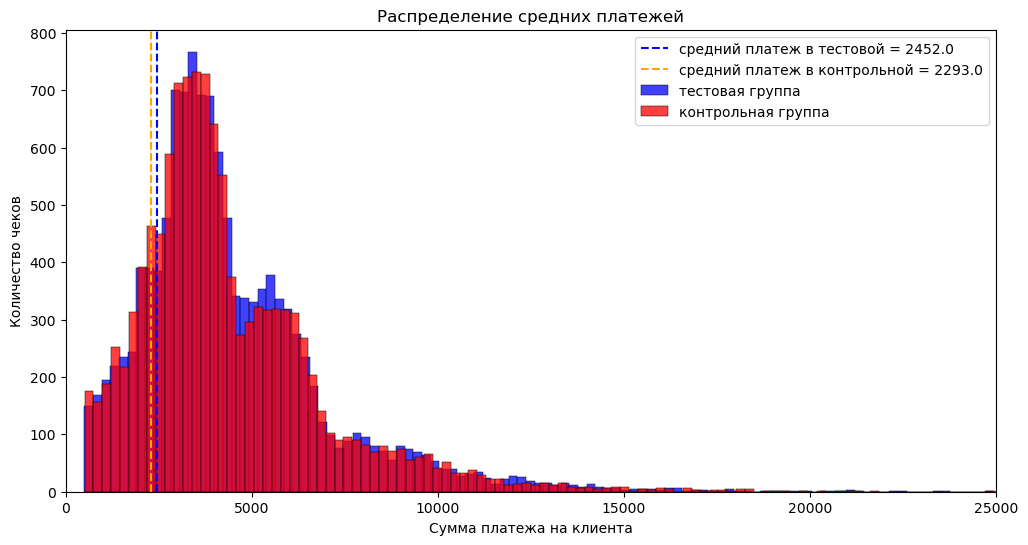

In [28]:
df_test = df_test_final[df_test_final['nflag_test']==1]
df_control = df_test_final[df_test_final['nflag_test']==0]

fig = plt.figure(figsize=(12,6))
ax1 = sns.histplot(df_test[df_test['amt_payment']>0]['amt_payment'], color='blue', label='тестовая группа')
bx2 = sns.histplot(df_control[df_control['amt_payment']>0]['amt_payment'], color='red', label ='контрольная группа')

mean_test = round(df_test['amt_payment'].mean(),0)
mean_control = round(df_control['amt_payment'].mean(),0)

plt.title('Распределение средних платежей')
plt.ylabel('Количество чеков')
plt.xlabel('Сумма платежа на клиента')

plt.axvline(mean_test, color = 'blue', linestyle='--', label=f'средний платеж в тестовой = {mean_test}')
plt.axvline(mean_control, color = 'orange', linestyle='--', label = f'средний платеж в контрольной = {mean_control}')
plt.legend(loc = 'upper right')

ax1.set_xlim([0,25000])

plt.show()

# Проверяем значимость разницы в платежах на клиента

In [29]:
test_calc(df_test['amt_payment'], df_control['amt_payment'])


Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  158.91123610796285


(5.663915722973564, 1.488511135509387e-08)

# Проверяем значимость разницы в количестве заказов на клиента

In [30]:
test_calc(df_test['id_order'], df_control['id_order'])

Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  0.03337029166356664


(4.603111364063375, 4.173532655020992e-06)

# Проверяем значимость разницы в конверсии

In [31]:
test_calc(df_test['flag_payment'], df_control['flag_payment'])

Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  0.02520549875986211


(5.377160738040539, 7.604318948190198e-08)

In [32]:
# агрегируем данные

df_test_final_gr = df_test_final.groupby('nflag_test')\
                        .agg({'id_client':'count','flag_payment':'sum','id_order':'sum', 'amt_payment':'sum'})\
                        .reset_index()
df_test_final_gr['conv'] = df_test_final_gr['flag_payment']/df_test_final_gr['id_client']
df_test_final_gr['cnt_orders'] = df_test_final_gr['id_order']/df_test_final_gr['flag_payment']
df_test_final_gr['avg_amt'] = df_test_final_gr['amt_payment']/df_test_final_gr['id_client']
df_test_final_gr

,nflag_test,id_client,flag_payment,id_order,amt_payment,conv,cnt_orders,avg_amt
0,0,22873,11850,14910.0,52456163.0,0.518078,1.258228,2293.366109
1,1,22445,12194,15380.0,55041365.0,0.543284,1.261276,2452.277345


In [33]:
# проверяем статистическую значимость разницы в конверсии с помощью Хи-квадрат

chi_sqr(df_test_final_gr['flag_payment'],df_test_final_gr['id_client'])

pval =  7.634301798104184e-08
Гипотеза Н0 не подтверждена. Рост конверсии статистически значимый



# Проверяем значимость разницы в количестве заказов на клиента

In [34]:
test_calc(df_test['id_order'], df_control['id_order'])

Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  0.03337029166356664


(4.603111364063375, 4.173532655020992e-06)

# Проверяем насколько распределения платежей равны

In [35]:
mann_whitney_func(df_test['amt_payment'], df_control['amt_payment'])

Распределения не равны


# Сегментация результатов АБ Теста

In [36]:
# Функция для прорисовки гистограммы по распределению платежей в АВ-тесте по городам и ТТ и расчете стат.критериев.

def histplot(df, city, point):
    df_c_test = df[df['nflag_test']==1]
    df_c_control = df[df['nflag_test']==0]

    fig = plt.figure(figsize=(7,4))
    ax1 = sns.histplot(df_c_test[df_c_test['amt_payment']>0]['amt_payment'], color='blue', label='тестовая группа')
    bx2 = sns.histplot(df_c_control[df_c_control['amt_payment']>0]['amt_payment'], color='red', label ='контрольная группа')

    mean_test_c = round(df_c_test['amt_payment'].mean(),0)
    mean_control_c = round(df_c_control['amt_payment'].mean(),0)

    plt.title(f'Распределение средних платежей в г.{city} ТТ= {point}')
    plt.ylabel('Количество чеков')
    plt.xlabel('Сумма платежа на клиента')

    plt.axvline(mean_test_c, color = 'blue', linestyle='--', label=f'средний платеж в тестовой = {mean_test_c}')
    plt.axvline(mean_control_c, color = 'orange', linestyle='--', label = f'средний платеж в контрольной = {mean_control_c}')
    plt.legend(loc = 'upper right')

    ax1.set_xlim([0,25000])

    plt.show()
    
    print(f'ВЫВОДЫ по г.{city} в ТТ {point} :')
    print()
    print('Результат сравнения распределения платежей в тестовой и контрольной группах')
    mann_whitney_func(df_c_test['amt_payment'], df_c_control['amt_payment'])
    print()
    
    print('Анализ разницы в размере платежа на клиента')
    test_calc(df_c_test['amt_payment'], df_c_control['amt_payment'])
    print()
    
    print('Анализ разницы в конверсии')
    test_calc(df_c_test['flag_payment'], df_c_control['flag_payment'])
    print()
    
    print('Анализ разницы в количестве заказов на клиента')
    test_calc(df_c_test['id_order'], df_c_control['id_order'])
    print()
    

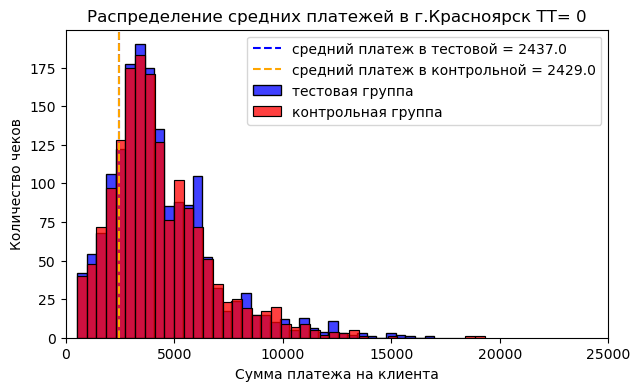

ВЫВОДЫ по г.Красноярск в ТТ 0 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в конверсии
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в количестве заказов на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0



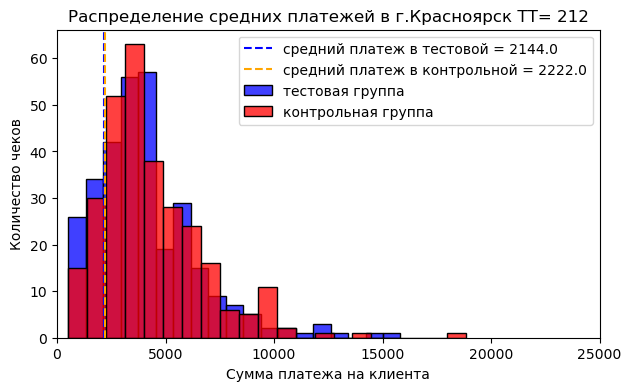

ВЫВОДЫ по г.Красноярск в ТТ 212 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в конверсии
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в количестве заказов на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0



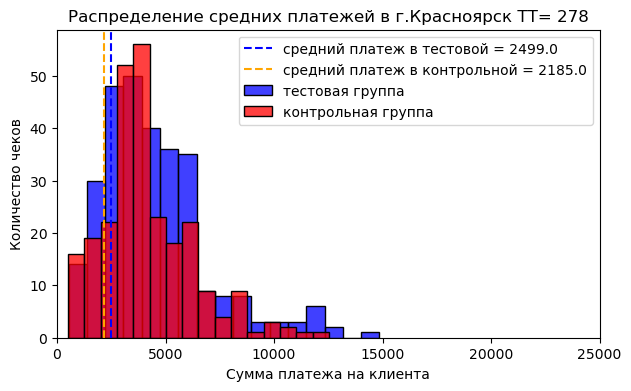

ВЫВОДЫ по г.Красноярск в ТТ 278 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в конверсии
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в количестве заказов на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0



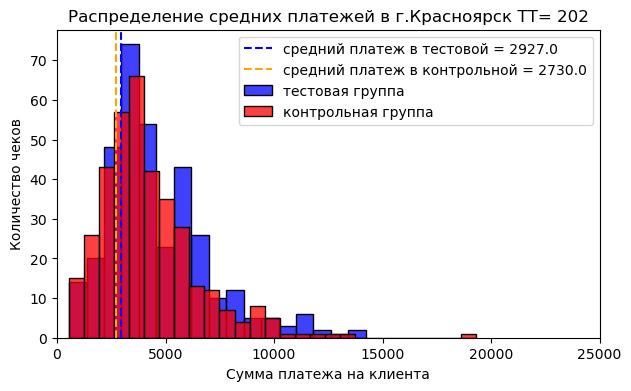

ВЫВОДЫ по г.Красноярск в ТТ 202 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в конверсии
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в количестве заказов на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0



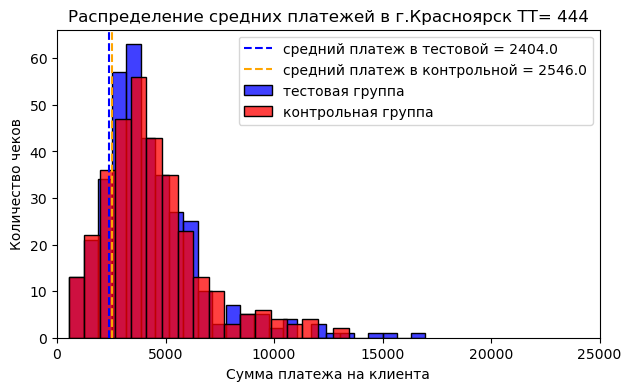

ВЫВОДЫ по г.Красноярск в ТТ 444 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в конверсии
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в количестве заказов на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0



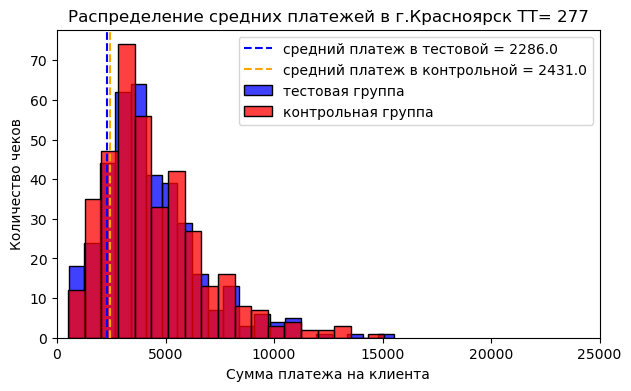

ВЫВОДЫ по г.Красноярск в ТТ 277 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в конверсии
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в количестве заказов на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0



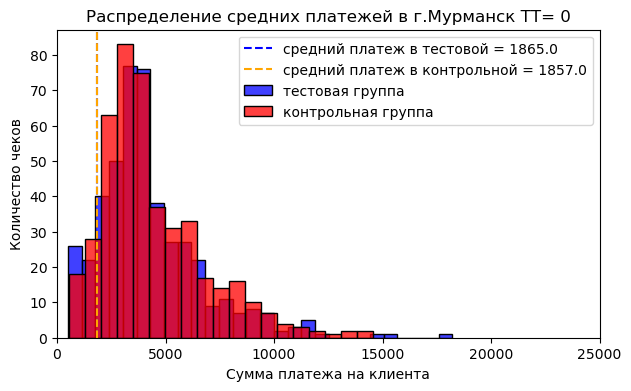

ВЫВОДЫ по г.Мурманск в ТТ 0 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в конверсии
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в количестве заказов на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0



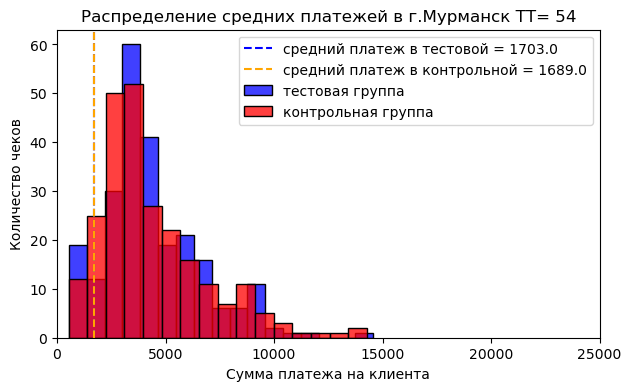

ВЫВОДЫ по г.Мурманск в ТТ 54 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в конверсии
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в количестве заказов на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0



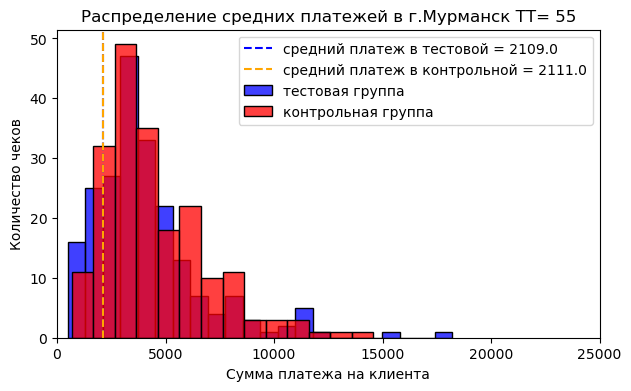

ВЫВОДЫ по г.Мурманск в ТТ 55 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в конверсии
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в количестве заказов на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0



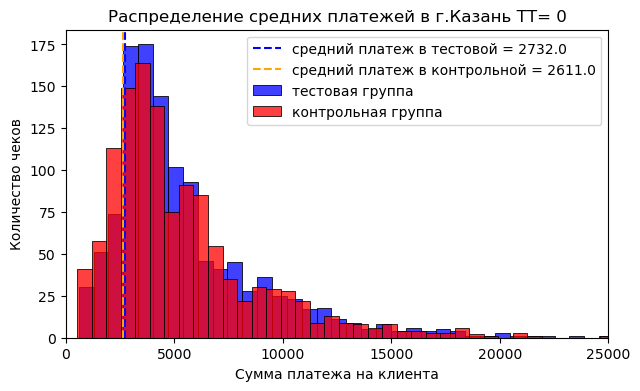

ВЫВОДЫ по г.Казань в ТТ 0 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в конверсии
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в количестве заказов на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0



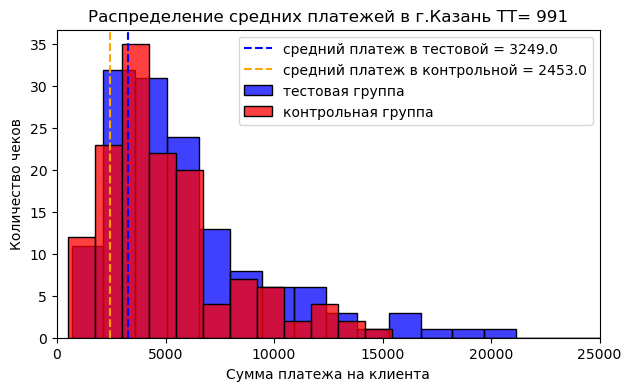

ВЫВОДЫ по г.Казань в ТТ 991 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  796.2950869236583

Анализ разницы в конверсии
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в количестве заказов на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0



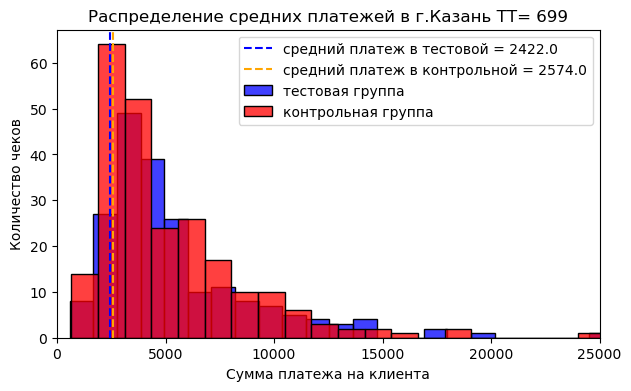

ВЫВОДЫ по г.Казань в ТТ 699 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в конверсии
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в количестве заказов на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0



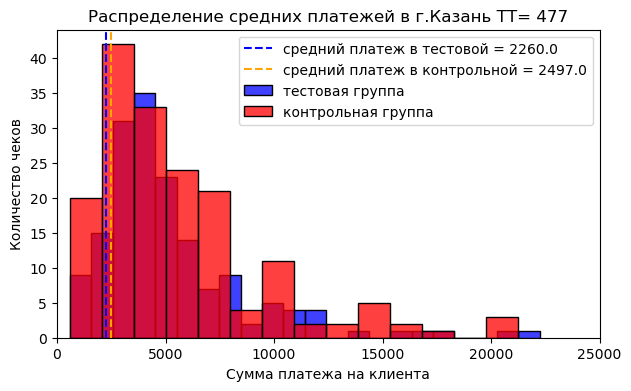

ВЫВОДЫ по г.Казань в ТТ 477 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в конверсии
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в количестве заказов на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0



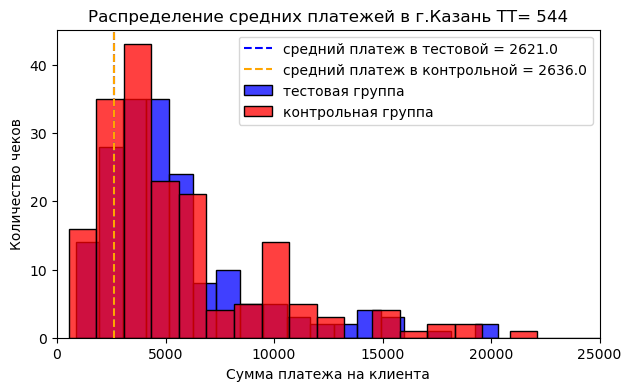

ВЫВОДЫ по г.Казань в ТТ 544 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в конверсии
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в количестве заказов на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0



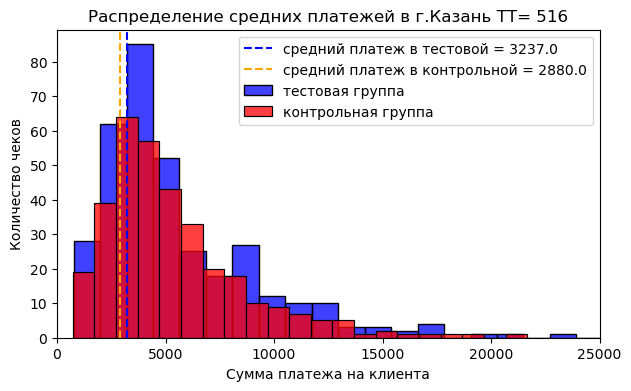

ВЫВОДЫ по г.Казань в ТТ 516 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в конверсии
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в количестве заказов на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0



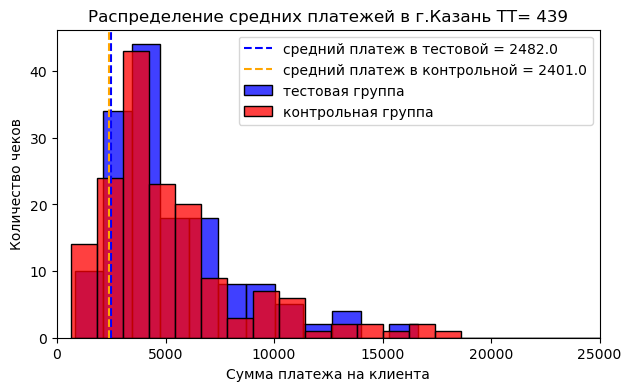

ВЫВОДЫ по г.Казань в ТТ 439 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в конверсии
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в количестве заказов на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0



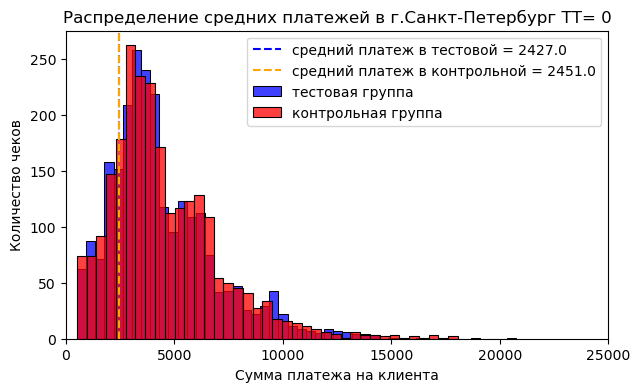

ВЫВОДЫ по г.Санкт-Петербург в ТТ 0 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в конверсии
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в количестве заказов на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0



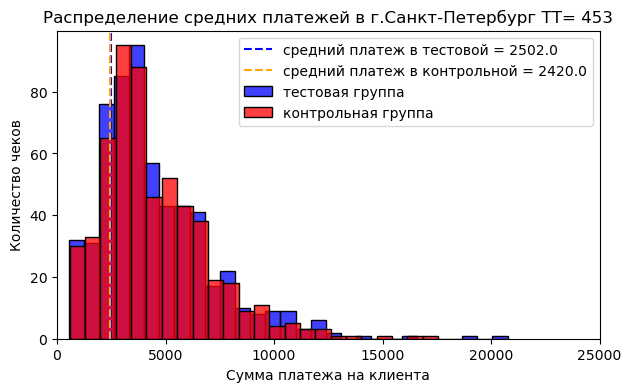

ВЫВОДЫ по г.Санкт-Петербург в ТТ 453 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в конверсии
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в количестве заказов на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0



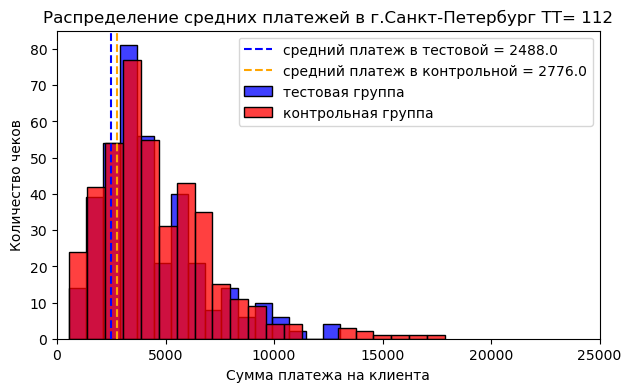

ВЫВОДЫ по г.Санкт-Петербург в ТТ 112 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в конверсии
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в количестве заказов на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0



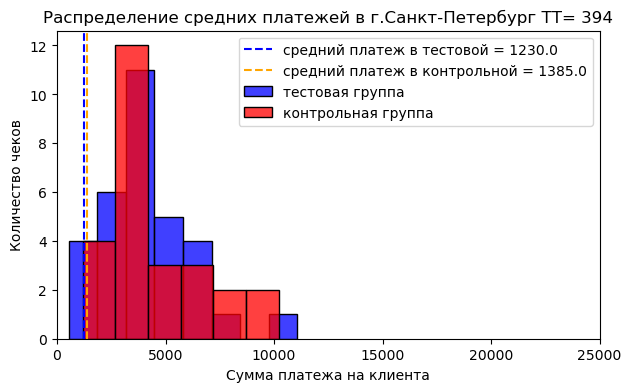

ВЫВОДЫ по г.Санкт-Петербург в ТТ 394 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в конверсии
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в количестве заказов на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0



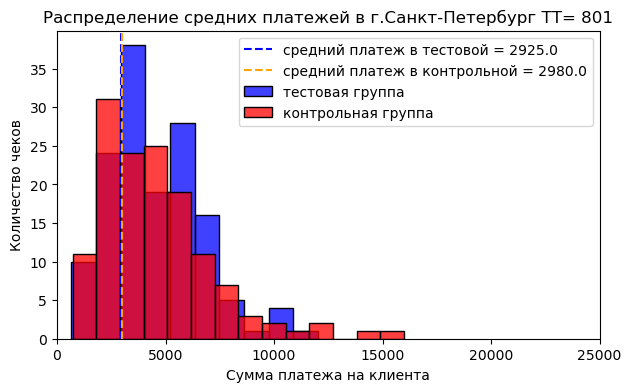

ВЫВОДЫ по г.Санкт-Петербург в ТТ 801 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в конверсии
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в количестве заказов на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0



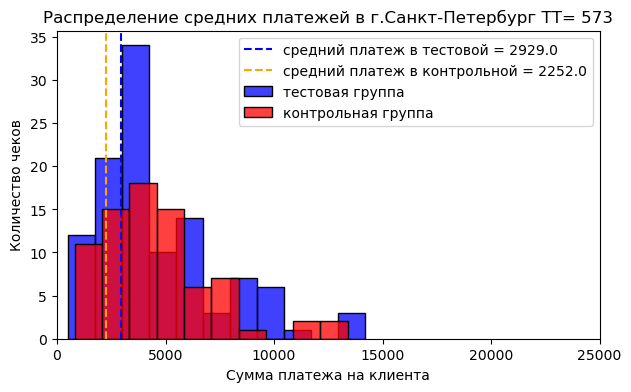

ВЫВОДЫ по г.Санкт-Петербург в ТТ 573 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения не равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  676.6951977401131

Анализ разницы в конверсии
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  0.1458686440677966

Анализ разницы в количестве заказов на клиента
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  0.21800847457627115



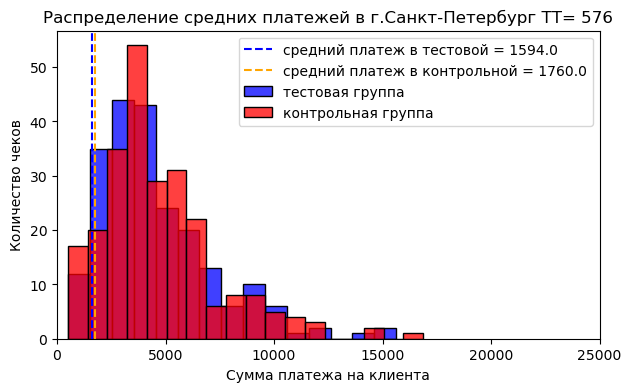

ВЫВОДЫ по г.Санкт-Петербург в ТТ 576 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в конверсии
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в количестве заказов на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0



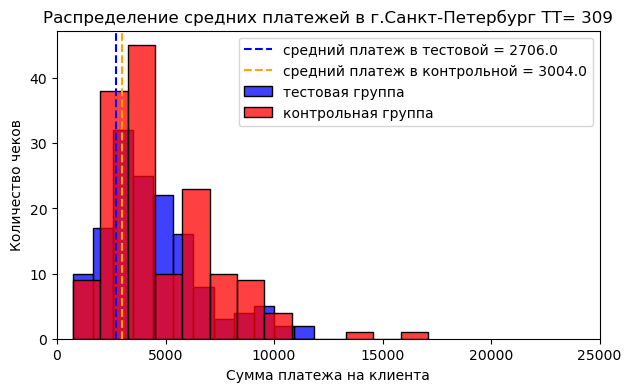

ВЫВОДЫ по г.Санкт-Петербург в ТТ 309 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в конверсии
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в количестве заказов на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0



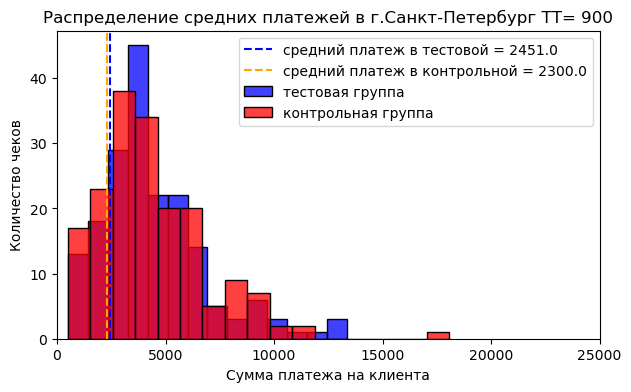

ВЫВОДЫ по г.Санкт-Петербург в ТТ 900 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в конверсии
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в количестве заказов на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0



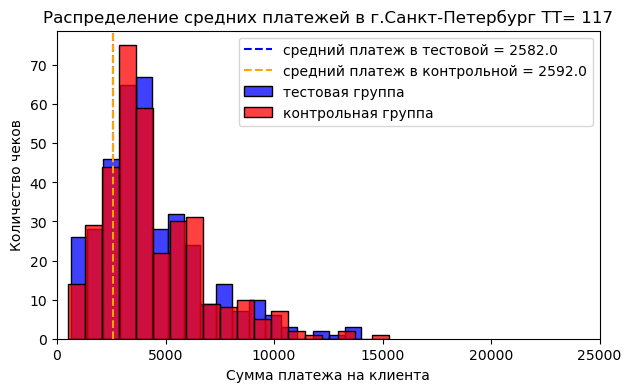

ВЫВОДЫ по г.Санкт-Петербург в ТТ 117 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в конверсии
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в количестве заказов на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0



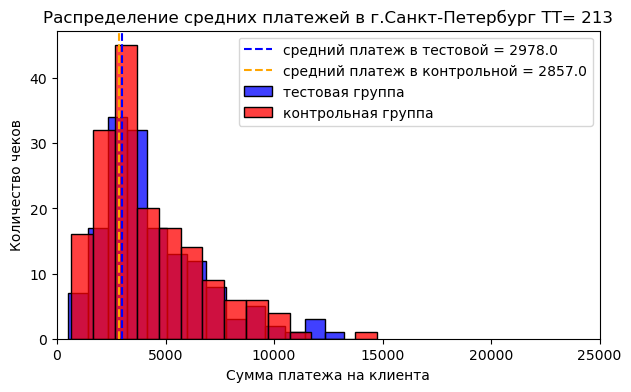

ВЫВОДЫ по г.Санкт-Петербург в ТТ 213 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в конверсии
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в количестве заказов на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0



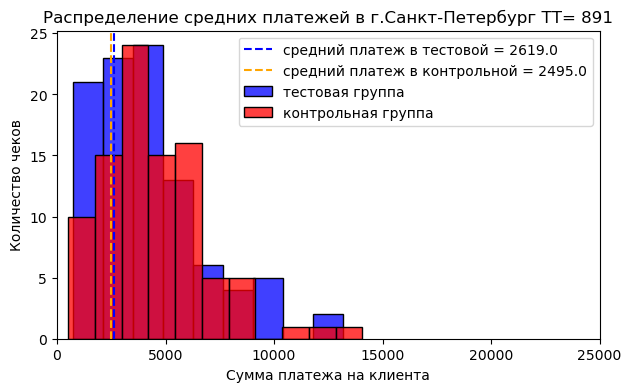

ВЫВОДЫ по г.Санкт-Петербург в ТТ 891 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в конверсии
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в количестве заказов на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0



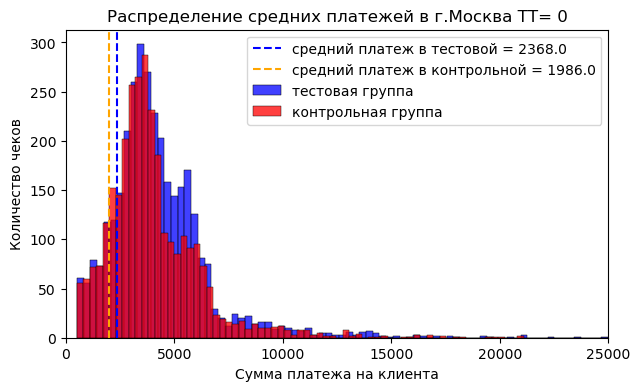

ВЫВОДЫ по г.Москва в ТТ 0 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения не равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  381.7784892750842

Анализ разницы в конверсии
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  0.05557800593933432

Анализ разницы в количестве заказов на клиента
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  0.06487262198224242



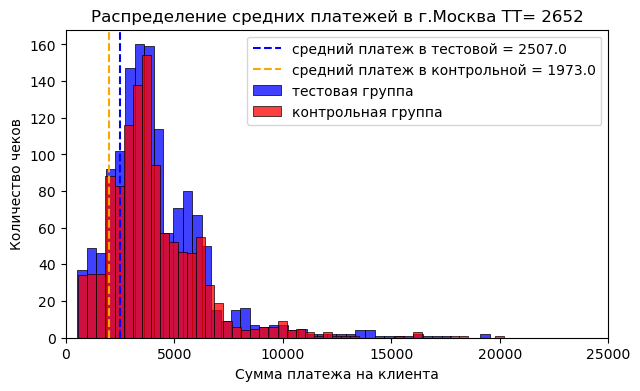

ВЫВОДЫ по г.Москва в ТТ 2652 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения не равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  533.7691266583877

Анализ разницы в конверсии
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  0.1083107326698855

Анализ разницы в количестве заказов на клиента
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  0.1356589276797333



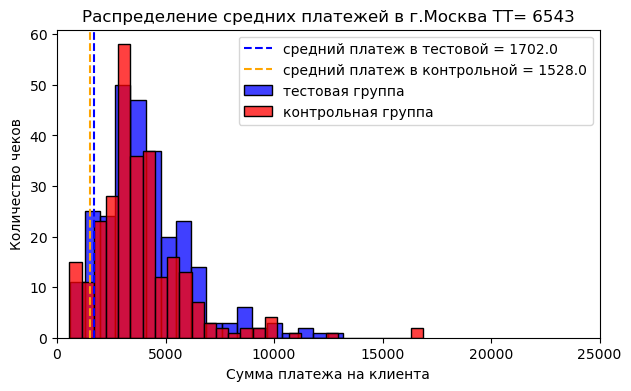

ВЫВОДЫ по г.Москва в ТТ 6543 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в конверсии
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в количестве заказов на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0



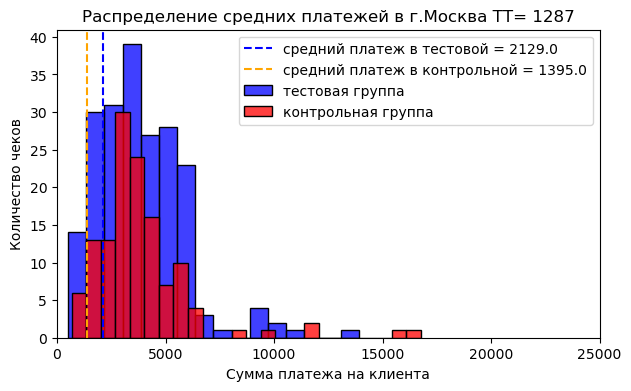

ВЫВОДЫ по г.Москва в ТТ 1287 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения не равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  733.901294571883

Анализ разницы в конверсии
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  0.19000681353622534

Анализ разницы в количестве заказов на клиента
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  0.20764630176394888



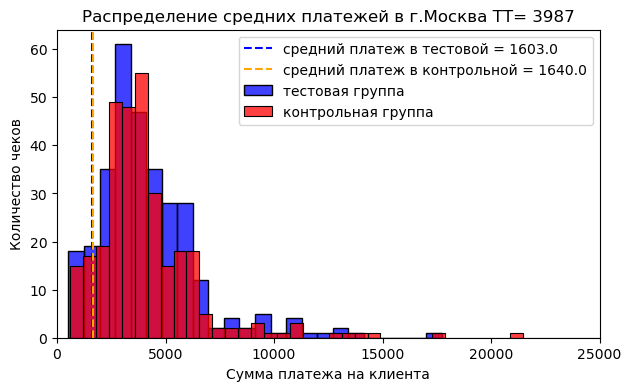

ВЫВОДЫ по г.Москва в ТТ 3987 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в конверсии
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в количестве заказов на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0



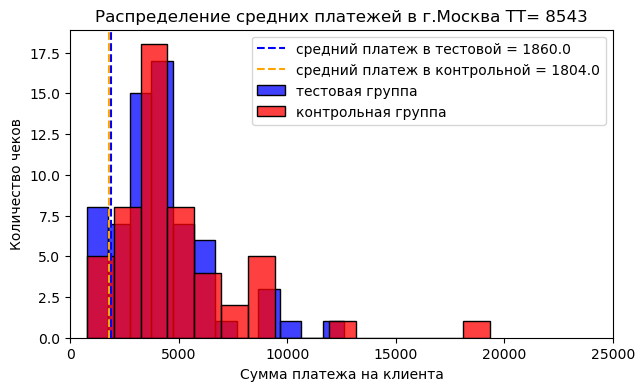

ВЫВОДЫ по г.Москва в ТТ 8543 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в конверсии
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в количестве заказов на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0



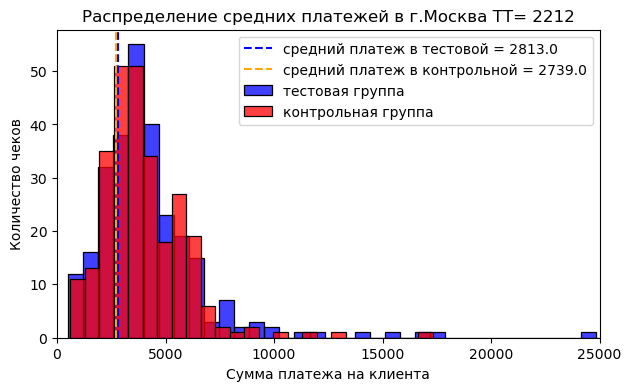

ВЫВОДЫ по г.Москва в ТТ 2212 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в конверсии
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в количестве заказов на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0



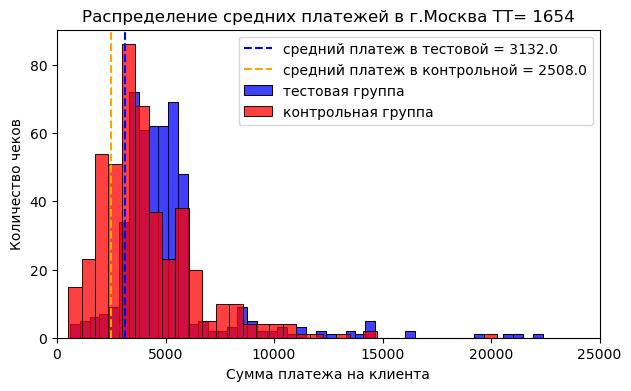

ВЫВОДЫ по г.Москва в ТТ 1654 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения не равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  624.4151754208888

Анализ разницы в конверсии
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в количестве заказов на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0



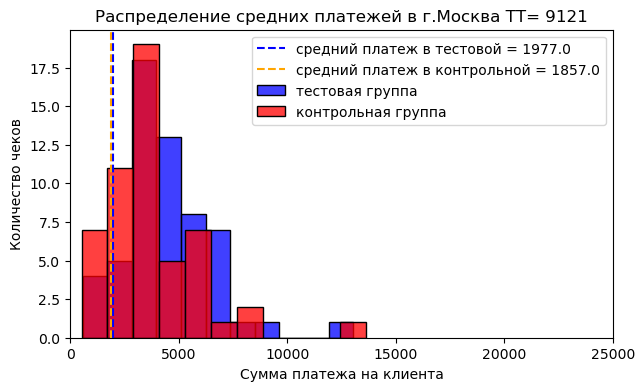

ВЫВОДЫ по г.Москва в ТТ 9121 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в конверсии
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в количестве заказов на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0



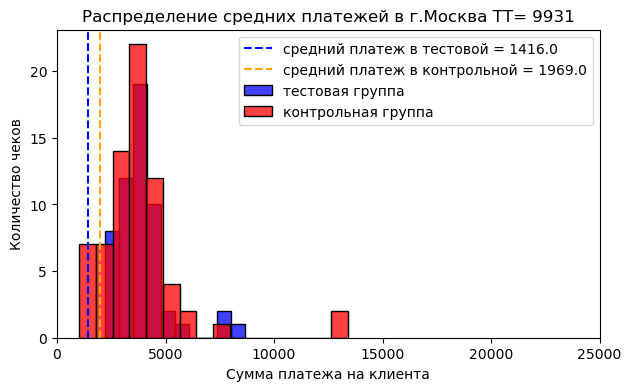

ВЫВОДЫ по г.Москва в ТТ 9931 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения не равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  -552.909116931444

Анализ разницы в конверсии
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  -0.15877105099947525

Анализ разницы в количестве заказов на клиента
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  -0.19832069080673626



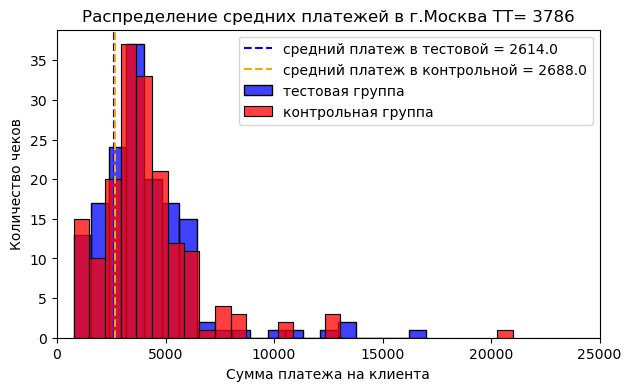

ВЫВОДЫ по г.Москва в ТТ 3786 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в конверсии
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в количестве заказов на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0



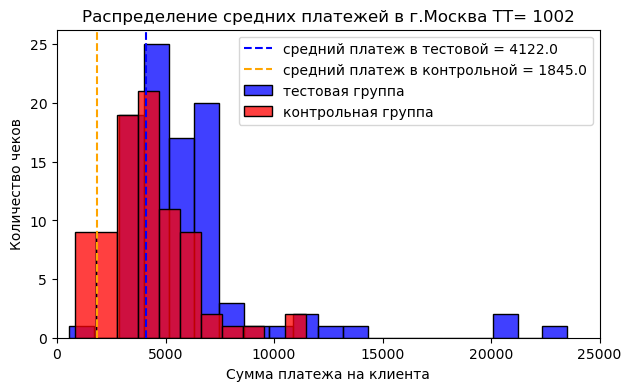

ВЫВОДЫ по г.Москва в ТТ 1002 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения не равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  2276.966389145853

Анализ разницы в конверсии
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  0.23435090965155725

Анализ разницы в количестве заказов на клиента
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  0.32947887758248534



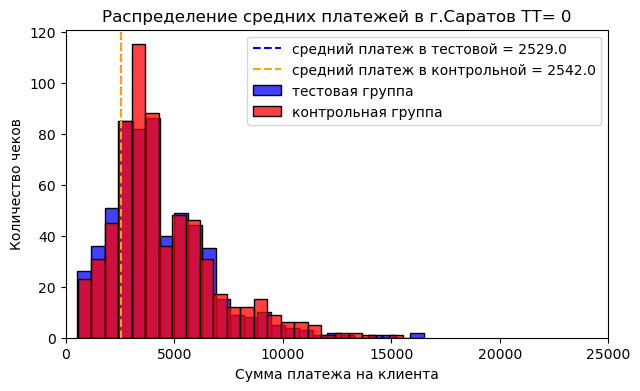

ВЫВОДЫ по г.Саратов в ТТ 0 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в конверсии
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в количестве заказов на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0



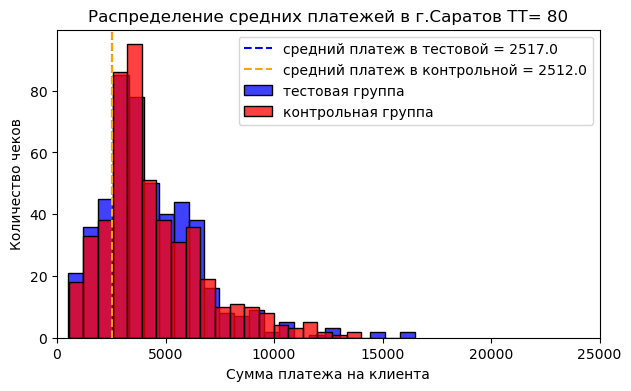

ВЫВОДЫ по г.Саратов в ТТ 80 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в конверсии
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в количестве заказов на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0



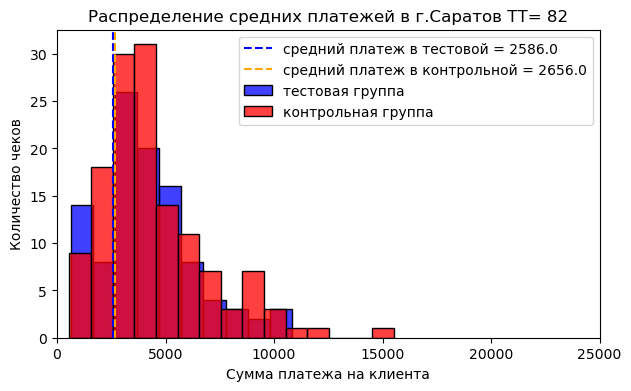

ВЫВОДЫ по г.Саратов в ТТ 82 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в конверсии
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в количестве заказов на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0



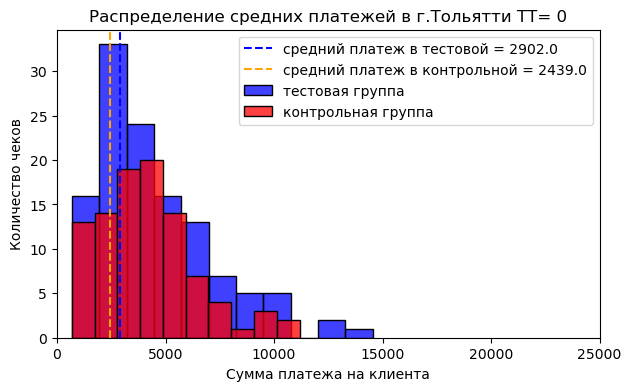

ВЫВОДЫ по г.Тольятти в ТТ 0 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в конверсии
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в количестве заказов на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0



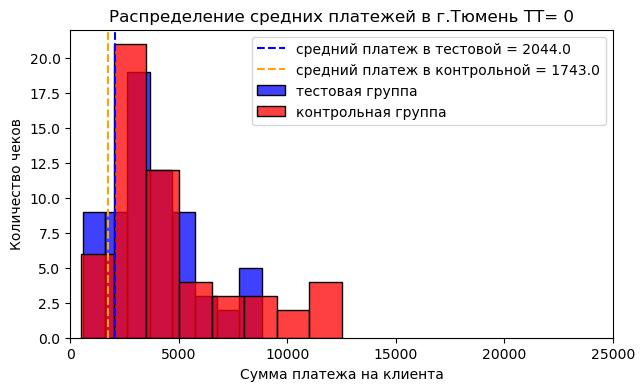

ВЫВОДЫ по г.Тюмень в ТТ 0 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения не равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в конверсии
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  0.1463645943097998

Анализ разницы в количестве заказов на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0



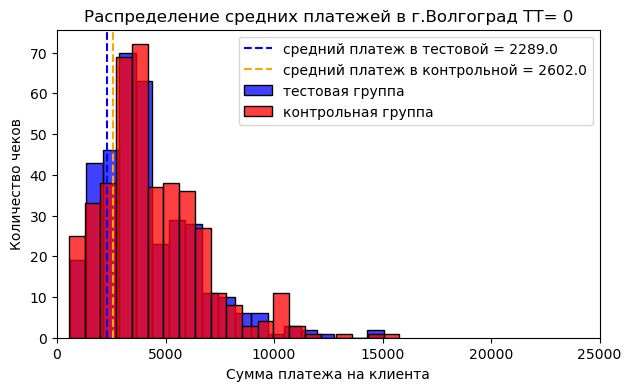

ВЫВОДЫ по г.Волгоград в ТТ 0 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения не равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  -312.89040013337035

Анализ разницы в конверсии
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в количестве заказов на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0



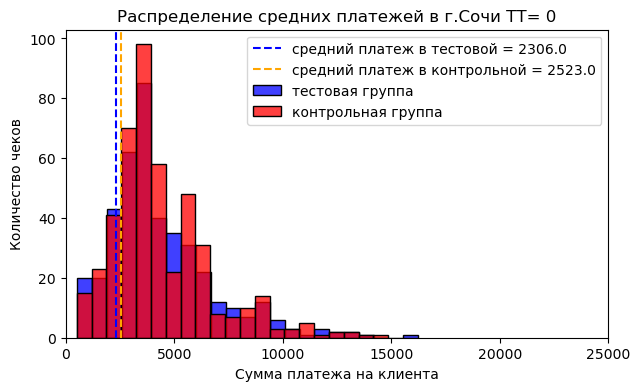

ВЫВОДЫ по г.Сочи в ТТ 0 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в конверсии
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  -0.04931605920420967

Анализ разницы в количестве заказов на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0



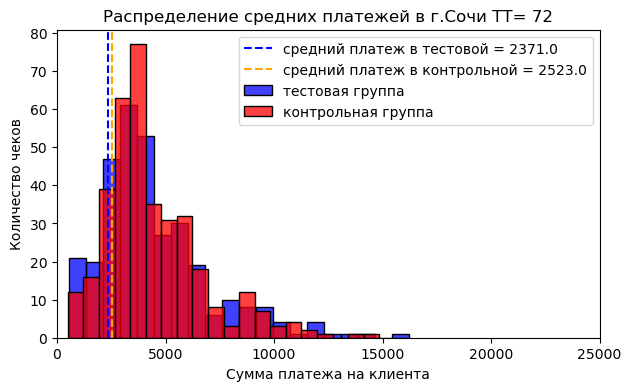

ВЫВОДЫ по г.Сочи в ТТ 72 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в конверсии
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в количестве заказов на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0



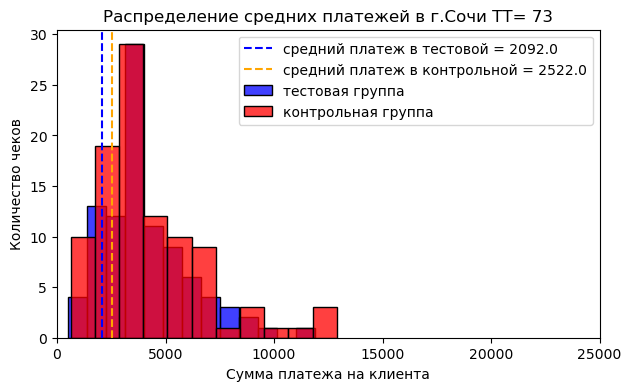

ВЫВОДЫ по г.Сочи в ТТ 73 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в конверсии
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в количестве заказов на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0



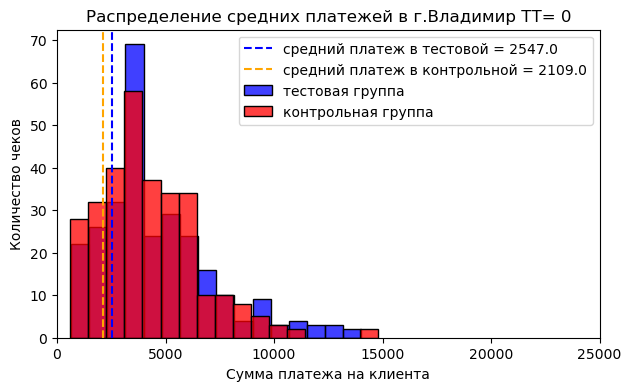

ВЫВОДЫ по г.Владимир в ТТ 0 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения не равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  438.6098419243094

Анализ разницы в конверсии
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в количестве заказов на клиента
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  0.09743692482680177



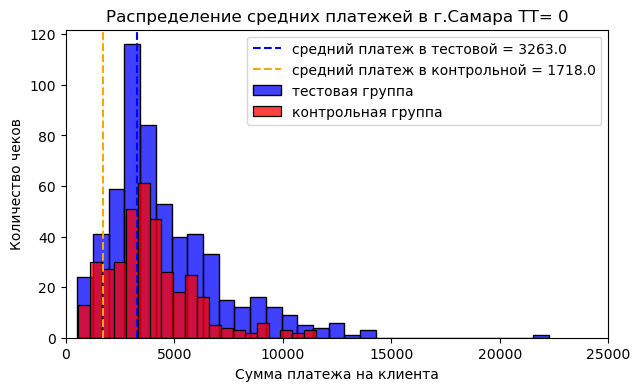

ВЫВОДЫ по г.Самара в ТТ 0 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения не равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  1544.3720191247648

Анализ разницы в конверсии
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  0.2772412939282998

Анализ разницы в количестве заказов на клиента
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  0.43640897755610975



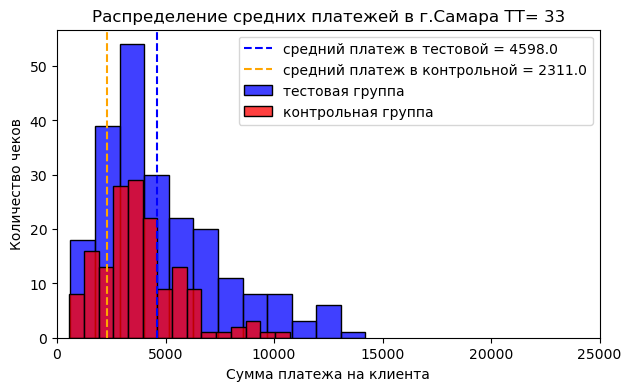

ВЫВОДЫ по г.Самара в ТТ 33 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения не равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  2286.832230686982

Анализ разницы в конверсии
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  0.3436246992782679

Анализ разницы в количестве заказов на клиента
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  0.6454156642608929



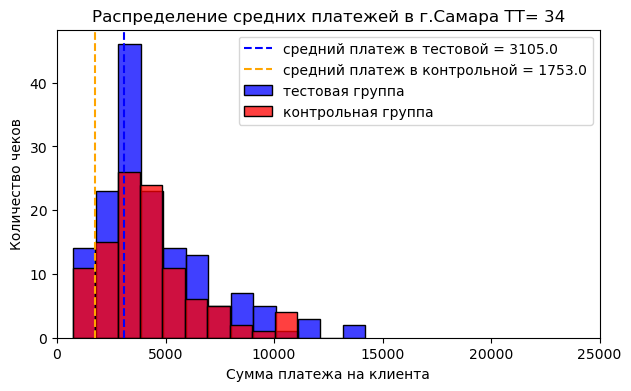

ВЫВОДЫ по г.Самара в ТТ 34 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения не равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  1351.8979710144927

Анализ разницы в конверсии
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  0.27831357048748356

Анализ разницы в количестве заказов на клиента
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  0.36815107597716296



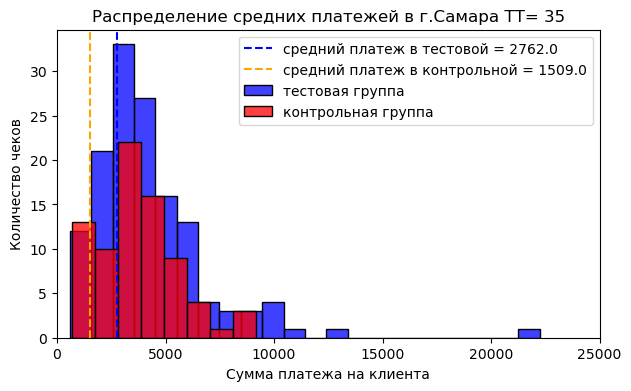

ВЫВОДЫ по г.Самара в ТТ 35 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения не равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  1253.3892475190287

Анализ разницы в конверсии
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  0.24747085461027074

Анализ разницы в количестве заказов на клиента
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  0.3950765969746604



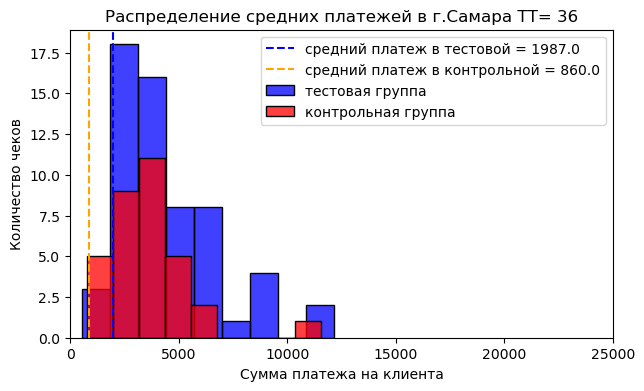

ВЫВОДЫ по г.Самара в ТТ 36 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения не равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  1126.909804558497

Анализ разницы в конверсии
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  0.22397271398408314

Анализ разницы в количестве заказов на клиента
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  0.2811975529207948



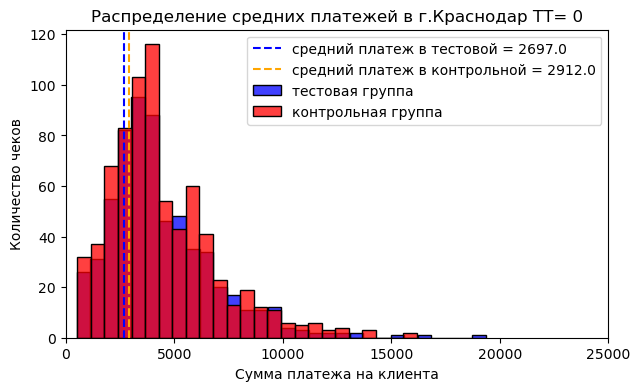

ВЫВОДЫ по г.Краснодар в ТТ 0 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в конверсии
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в количестве заказов на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0



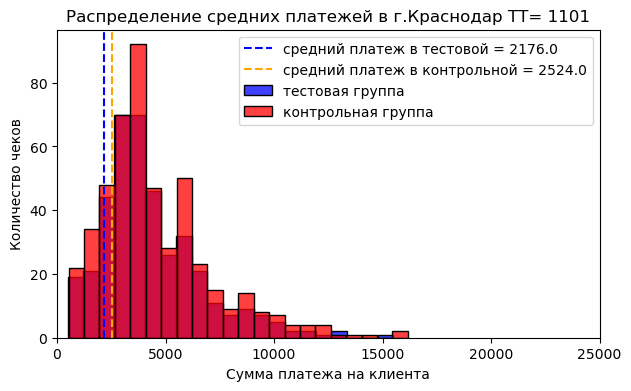

ВЫВОДЫ по г.Краснодар в ТТ 1101 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения не равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  -347.5750045810032

Анализ разницы в конверсии
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  -0.05250342659034102

Анализ разницы в количестве заказов на клиента
Гипотеза H0 не подтверждается: Статистическая разница подтверждена
Разница средних =  -0.091807700483021



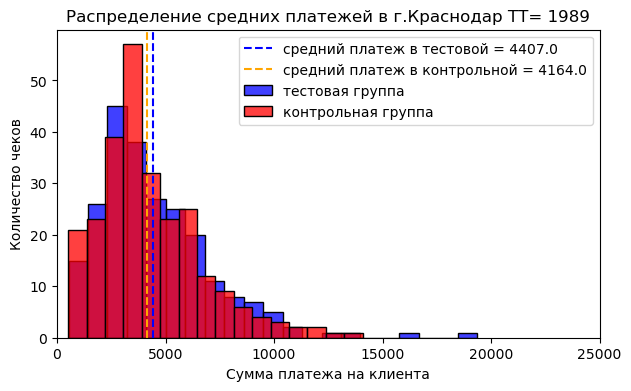

ВЫВОДЫ по г.Краснодар в ТТ 1989 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в конверсии
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в количестве заказов на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0



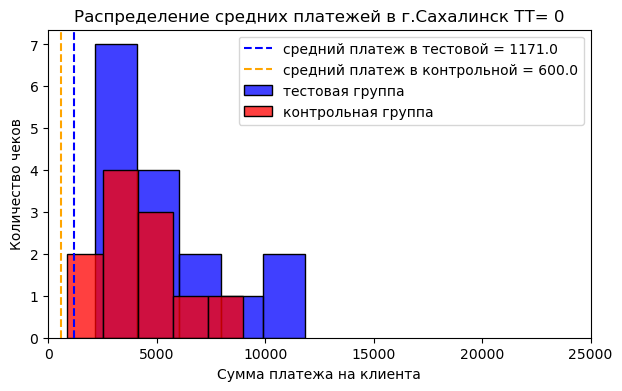

ВЫВОДЫ по г.Сахалинск в ТТ 0 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в конверсии
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в количестве заказов на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0



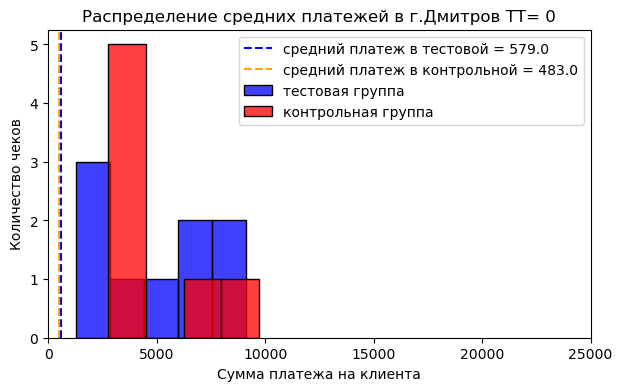

ВЫВОДЫ по г.Дмитров в ТТ 0 :

Результат сравнения распределения платежей в тестовой и контрольной группах
Распределения равны

Анализ разницы в размере платежа на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в конверсии
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0

Анализ разницы в количестве заказов на клиента
Гипотеза H0 подтверждается: Средние статистически равны
Разница средних = 0



In [37]:
# Аналитика по городу вцелом и по каждой ТТ этого города отдельно

for i in df_test_final['city'].unique():
    
    df_city = df_test_final[df_test_final['city']==i]
    histplot(df_city, i, 0)
    
    if df_city['id_trading_point'].nunique() >1: # не еще раз график, если ТТ одна в городе
        
        for j in df_city['id_trading_point'].unique():
            df_point = df_city[df_city['id_trading_point']==j]
            histplot(df_point, i, j)

# Отчет по АБ Тесту

In [39]:
columns_res={'city':[], \
             'id_trading_point':[],\
             'clients_test':[],\
             'clients_control':[],\
             'count_all':[],\
             'payments_test':[],\
             'payments_control':[],\
             'diff':[],\
             'sigma_test':[],\
             'sigma_control':[],\
             'ttest':[],\
             'pvalue_ttest':[],\
             'pvalue_ttest_conv':[]}
df_res =pd.DataFrame(columns_res)

for i in df_test_final['id_trading_point'].unique():
    
    dff = df_test_final[df_test_final['id_trading_point']== i] 
    
    cnt_test = len(dff[dff['nflag_test']==1])
    cnt_control = len(dff[dff['nflag_test']==0])
    cnt_all= cnt_test + cnt_control
    avg_test = dff[dff['nflag_test']==1]['amt_payment'].mean()
    avg_control = dff[dff['nflag_test']==0]['amt_payment'].mean()
    diff = avg_test - avg_control
    s_test = dff[dff['nflag_test']==1]['amt_payment'].std()
    s_control = dff[dff['nflag_test']==0]['amt_payment'].std()
    s_amt, p_amt = ttest_ind(dff[dff['nflag_test']==1]['amt_payment'],dff[dff['nflag_test']==0]['amt_payment'])
    s_conv, p_conv = ttest_ind(dff[dff['nflag_test']==1]['flag_payment'],dff[dff['nflag_test']==0]['flag_payment'])
    
    metrics = {'city':dff['city'].unique(), \
             'id_trading_point':[i],\
             'clients_test':[cnt_test],\
             'clients_control':[cnt_control],\
             'count_all':[cnt_all],\
             'payments_test':[avg_test],\
             'payments_control':[avg_control],\
             'diff':[diff],\
             'sigma_test':[s_test],\
             'sigma_control':[s_control],\
             'ttest':[s_amt],\
             'pvalue_ttest':[p_amt],\
             'pvalue_ttest_conv':[p_conv]}
    
    list_by_point = pd.DataFrame(metrics)
    df_res = pd.concat([df_res,list_by_point],ignore_index=True).sort_values(by=['city','id_trading_point','count_all'])
df_res.head(5)

,city,id_trading_point,clients_test,clients_control,count_all,payments_test,payments_control,diff,sigma_test,sigma_control,ttest,pvalue_ttest,pvalue_ttest_conv
0,Владимир,11.0,509.0,608.0,1117.0,2547.220039,2108.610197,438.609842,3023.702164,2663.038392,2.576955,0.010095,0.084816
1,Волгоград,66.0,657.0,703.0,1360.0,2288.870624,2601.761024,-312.890400,2682.567610,2830.193773,-2.089272,0.036869,0.104989
2,Дмитров,2.0,78.0,71.0,149.0,579.333333,483.450704,95.882629,1860.762430,1654.923182,0.331052,0.741076,0.742942
3,Казань,439.0,355.0,351.0,706.0,2481.960563,2400.635328,81.325236,4040.441007,3722.117072,0.278067,0.781042,0.662159
4,Казань,477.0,382.0,386.0,768.0,2259.623037,2496.987047,-237.364010,3482.846094,3881.994719,-0.891593,0.372891,0.756852


In [41]:
df_res['percent_count'] = df_res['count_all']/df_res['count_all'].sum()
df_res['nflag_diff'] = np.where((df_res['diff'] >0) & (df_res['pvalue_ttest']<0.05), 'Positive',\
                                np.where((df_res['diff'] <0) & (df_res['pvalue_ttest']<0.05), 'Negative', 'No_diff'))
df_res.head(5)

,city,id_trading_point,clients_test,clients_control,count_all,payments_test,payments_control,diff,sigma_test,sigma_control,ttest,pvalue_ttest,pvalue_ttest_conv,percent_count,nflag_diff
0,Владимир,11.0,509.0,608.0,1117.0,2547.220039,2108.610197,438.609842,3023.702164,2663.038392,2.576955,0.010095,0.084816,0.024648,Positive
1,Волгоград,66.0,657.0,703.0,1360.0,2288.870624,2601.761024,-312.890400,2682.567610,2830.193773,-2.089272,0.036869,0.104989,0.030010,Negative
2,Дмитров,2.0,78.0,71.0,149.0,579.333333,483.450704,95.882629,1860.762430,1654.923182,0.331052,0.741076,0.742942,0.003288,No_diff
3,Казань,439.0,355.0,351.0,706.0,2481.960563,2400.635328,81.325236,4040.441007,3722.117072,0.278067,0.781042,0.662159,0.015579,No_diff
4,Казань,477.0,382.0,386.0,768.0,2259.623037,2496.987047,-237.364010,3482.846094,3881.994719,-0.891593,0.372891,0.756852,0.016947,No_diff


# Выгружаем результаты в Excel

In [43]:
writer = pd.ExcelWriter('Сalculator AB test.xlsx')

# удаленные из исследования точки = некорректное деление для теста или отсутствие результатов.
defected_tp_final.to_excel(writer, sheet_name='Deleted_TP')

# Выгрузка на отдельные страницы результатов теста.
df_res[df_res['nflag_diff'] == 'Positive'].to_excel(writer, sheet_name='Positive')
df_res[df_res['nflag_diff'] == 'Negative'].to_excel(writer, sheet_name='Negative')
df_res[df_res['nflag_diff'] == 'No_diff'].to_excel(writer, sheet_name='No_diff')
df_res.to_excel(writer, sheet_name='Total_results')

writer.close()